<h1> Instalação das bibliotecas necessárias </h1>

In [2]:
!pip install --upgrade pip
!pip install pymongo
!pip install -U nltk
!pip install joblib
!pip install pandas
!pip install sklearn
!pip install matplotlib

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (19.2.3)
Requirement already up-to-date: nltk in /opt/conda/lib/python3.7/site-packages (3.4.5)


In [74]:
from pymongo import MongoClient
import pandas as pd
import re
import nltk

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.model_selection import cross_val_score
import matplotlib

#Download do corpus da nltk
nltk.download('stopwords')

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Definição das funções de leitura dos dados no MongoDb</h3>

In [4]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

In [5]:
def read_mongo(db, collection, query={}, host='ds249824.mlab.com', port='49824', username='app', password='nodeapp01', no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

<h3>Carrega os DataSets (tweets marcados como acidente e não acidente)</h3>
<p> Cria Dataset chamado "acidente", com os documentos rotulados como Sim.
<p> Cria Dataset chamado "nao acidente", com os documentos rotulados como Não.
<p> Cria Dataset chamado "full_data", com os documentos rotulados como todos.

In [6]:
acidente = read_mongo('labeling_zone','tweets',query={'label':'Sim'})
nao_acidente = read_mongo('labeling_zone','tweets',query={'label':'Não'})
full_data = acidente.append(nao_acidente)
#full_data = acidente.append(nao_acidente)

In [7]:
print('Total de documentos rotulados como "acidente": ' + str(len(acidente)))
print('Total de documentos rotulados como "Não acidente": ' + str(len(nao_acidente)))
print('Full Data: ' + str(len(full_data)))

full_data[['lang','location','texto','usuario','label']].head()

Total de documentos rotulados como "acidente": 277
Total de documentos rotulados como "Não acidente": 1506
Full Data: 1783


,lang,location,texto,usuario,label
0,pt,São Paulo,"As faixas foram liberadas na Rod Dom Pedro I (SP-065) no km 33, em Igaratá, região do Vale do Paraíba, após um grave acidente das 19h30 de ontem, na pista no sentido de Jacareí, envolvendo uma carreta, dois caminhões, um Fiat Fiorino e um Renault Sandero. #seumelhorcaminho",radiotransitofm,Sim
1,pt,"São Paulo/SP, Brasil","Um dos caminhões e a carreta tombaram no acidente, deixando cair na pista as cargas de peças de aç https://t.co/bgvms9jsTK (radiotransitofm)",TransitoSampaSP,Sim
2,pt,São Paulo,"Ouvintes relatam #acidente no km 39 da rodovia dos Bandeirantes, sentido SP. Lentidão de 1 km.",radiotransitofm,Sim
3,pt,São Paulo/SP - Brasil,"13h24 - Acidente de trânsito, carro x moto, na Rua Pedro de Toledo, 1651 – Vila Mariana. Uma vítima, masc., 39 anos, lesão em membro inferior direito. #193R",BombeirosPMESP,Sim
4,pt,"São Paulo/SP, Brasil","Acidente de trânsito, carro x moto, na R.Pedro de Toledo, 1651 – Vila Mariana. Uma vítima, masc., https://t.co/LNXwM9R7WR (@BombeirosPMESP)",TransitoSampaSP,Sim


<h2>Aplica as funções de Pré-Processamento</h2>
<ul> 
    <li>Remoção de Urls (regex)</li>
    <li>Conversão para minúsculo</li>
    <li>Tokenização</li>
    <li>Remoção de Stop Words</li>
    <li>Steming</li>    
</ul>

In [8]:
def remove_urls(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text)

def to_lower(text):
    return text.lower()

<p>Remoção de URLs</p>
<p>Conversão para Minúsculo</p>

In [9]:
full_data['texto_formatado'] = full_data['texto'].apply(lambda t: remove_urls(str(t)))
full_data['texto_formatado'] = full_data['texto_formatado'].apply(lambda t: to_lower(t))

<p> Tokenização (Conversão de frases em array de tokens)

In [10]:
#pd.options.display.max_colwidth = 100
tokenizer = TreebankWordTokenizer()
full_data['tokens'] = full_data['texto_formatado'].apply(lambda t: tokenizer.tokenize(t))
full_data[['texto_formatado','tokens']].head(10)

,texto_formatado,tokens
0,"as faixas foram liberadas na rod dom pedro i (sp-065) no km 33, em igaratá, região do vale do paraíba, após um grave acidente das 19h30 de ontem, na pista no sentido de jacareí, envolvendo uma carreta, dois caminhões, um fiat fiorino e um renault sandero. #seumelhorcaminho","[as, faixas, foram, liberadas, na, rod, dom, pedro, i, (, sp-065, ), no, km, 33, ,, em, igaratá, ,, região, do, vale, do, paraíba, ,, após, um, grave, acidente, das, 19h30, de, ontem, ,, na, pista, no, sentido, de, jacareí, ,, envolvendo, uma, carreta, ,, dois, caminhões, ,, um, fiat, fiorino, e, um, renault, sandero., #, seumelhorcaminho]"
1,"um dos caminhões e a carreta tombaram no acidente, deixando cair na pista as cargas de peças de aç","[um, dos, caminhões, e, a, carreta, tombaram, no, acidente, ,, deixando, cair, na, pista, as, cargas, de, peças, de, aç]"
2,"ouvintes relatam #acidente no km 39 da rodovia dos bandeirantes, sentido sp. lentidão de 1 km.","[ouvintes, relatam, #, acidente, no, km, 39, da, rodovia, dos, bandeirantes, ,, sentido, sp., lentidão, de, 1, km, .]"
3,"13h24 - acidente de trânsito, carro x moto, na rua pedro de toledo, 1651 – vila mariana. uma vítima, masc., 39 anos, lesão em membro inferior direito. #193r","[13h24, -, acidente, de, trânsito, ,, carro, x, moto, ,, na, rua, pedro, de, toledo, ,, 1651, –, vila, mariana., uma, vítima, ,, masc., ,, 39, anos, ,, lesão, em, membro, inferior, direito., #, 193r]"
4,"acidente de trânsito, carro x moto, na r.pedro de toledo, 1651 – vila mariana. uma vítima, masc.,","[acidente, de, trânsito, ,, carro, x, moto, ,, na, r.pedro, de, toledo, ,, 1651, –, vila, mariana., uma, vítima, ,, masc., ,]"
5,"bloqueio total do acesso do #rodoanel no sentido perus, pista interna, para a #imigrantes na direção do litoral. um caminhão-tanque tombou no local. houve vazamento de ácido clorídrico. ninguém ficou ferido neste acidente. a interdição acontece na altura do km 71.","[bloqueio, total, do, acesso, do, #, rodoanel, no, sentido, perus, ,, pista, interna, ,, para, a, #, imigrantes, na, direção, do, litoral., um, caminhão-tanque, tombou, no, local., houve, vazamento, de, ácido, clorídrico., ninguém, ficou, ferido, neste, acidente., a, interdição, acontece, na, altura, do, km, 71, .]"
6,"ouvintes relatam #acidente no km 39 da rodovia dos bandeirantes, sent sp. lentidão de 1 km (radiotransitofm)","[ouvintes, relatam, #, acidente, no, km, 39, da, rodovia, dos, bandeirantes, ,, sent, sp., lentidão, de, 1, km, (, radiotransitofm, )]"
7,"capotamento no #corredornortesul sentido santana, na altura de congonhas. ouvintes relatam o capotamento de uma van no local. uma faixa está bloqueada.","[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]"
8,"capotamento no #corredornortesul sentido santana, na altura de congonhas. ouvintes relatam o capotamento de uma van no local. uma faixa está bloqueada.","[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]"
9,"capotamento no #corredornortesul sentido santana, na altura de congonhas. ouvintes relatam o capotamento de uma van no local. uma faixa está bloqueada.","[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]"


In [11]:
def create_stopword_list():
    portuguese_stops = set(stopwords.words('portuguese'))
    portuguese_stops.add('rt')

    with open('punctuation.txt','r+') as punct_file:
        puncts = punct_file.readlines()

    for item in puncts:    
        portuguese_stops.add(item.strip())
        
    return portuguese_stops

stop_w = create_stopword_list()

#aplica a remocao de stop-words
full_data['words'] = full_data['tokens'].apply(lambda w: [word for word in w if word not in stop_w]) 
#exibe resultado intermediario
full_data[['tokens','words']].head(50)

,tokens,words
0,"[as, faixas, foram, liberadas, na, rod, dom, pedro, i, (, sp-065, ), no, km, 33, ,, em, igaratá, ,, região, do, vale, do, paraíba, ,, após, um, grave, acidente, das, 19h30, de, ontem, ,, na, pista, no, sentido, de, jacareí, ,, envolvendo, uma, carreta, ,, dois, caminhões, ,, um, fiat, fiorino, e, um, renault, sandero., #, seumelhorcaminho]","[faixas, liberadas, rod, dom, pedro, i, sp-065, km, 33, igaratá, região, vale, paraíba, após, grave, acidente, 19h30, ontem, pista, sentido, jacareí, envolvendo, carreta, dois, caminhões, fiat, fiorino, renault, sandero., seumelhorcaminho]"
1,"[um, dos, caminhões, e, a, carreta, tombaram, no, acidente, ,, deixando, cair, na, pista, as, cargas, de, peças, de, aç]","[caminhões, carreta, tombaram, acidente, deixando, cair, pista, cargas, peças, aç]"
2,"[ouvintes, relatam, #, acidente, no, km, 39, da, rodovia, dos, bandeirantes, ,, sentido, sp., lentidão, de, 1, km, .]","[ouvintes, relatam, acidente, km, 39, rodovia, bandeirantes, sentido, sp., lentidão, 1, km]"
3,"[13h24, -, acidente, de, trânsito, ,, carro, x, moto, ,, na, rua, pedro, de, toledo, ,, 1651, –, vila, mariana., uma, vítima, ,, masc., ,, 39, anos, ,, lesão, em, membro, inferior, direito., #, 193r]","[13h24, acidente, trânsito, carro, x, moto, rua, pedro, toledo, 1651, –, vila, mariana., vítima, masc., 39, anos, lesão, membro, inferior, direito., 193r]"
4,"[acidente, de, trânsito, ,, carro, x, moto, ,, na, r.pedro, de, toledo, ,, 1651, –, vila, mariana., uma, vítima, ,, masc., ,]","[acidente, trânsito, carro, x, moto, r.pedro, toledo, 1651, –, vila, mariana., vítima, masc.]"
5,"[bloqueio, total, do, acesso, do, #, rodoanel, no, sentido, perus, ,, pista, interna, ,, para, a, #, imigrantes, na, direção, do, litoral., um, caminhão-tanque, tombou, no, local., houve, vazamento, de, ácido, clorídrico., ninguém, ficou, ferido, neste, acidente., a, interdição, acontece, na, altura, do, km, 71, .]","[bloqueio, total, acesso, rodoanel, sentido, perus, pista, interna, imigrantes, direção, litoral., caminhão-tanque, tombou, local., vazamento, ácido, clorídrico., ninguém, ficou, ferido, neste, acidente., interdição, acontece, altura, km, 71]"
6,"[ouvintes, relatam, #, acidente, no, km, 39, da, rodovia, dos, bandeirantes, ,, sent, sp., lentidão, de, 1, km, (, radiotransitofm, )]","[ouvintes, relatam, acidente, km, 39, rodovia, bandeirantes, sent, sp., lentidão, 1, km, radiotransitofm]"
7,"[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]","[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]"
8,"[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]","[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]"
9,"[capotamento, no, #, corredornortesul, sentido, santana, ,, na, altura, de, congonhas., ouvintes, relatam, o, capotamento, de, uma, van, no, local., uma, faixa, está, bloqueada, .]","[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]"


In [12]:
print(len(stop_w))

240


In [13]:
portuguese_stops = set(stopwords.words('portuguese'))
print(len(portuguese_stops))

204


In [14]:
stemer= SnowballStemmer(language='portuguese')
full_data['stem_words'] = full_data['words'].apply(lambda t: [stemer.stem(word) for word in t])
full_data[['words','stem_words']].head(10)

,words,stem_words
0,"[faixas, liberadas, rod, dom, pedro, i, sp-065, km, 33, igaratá, região, vale, paraíba, após, grave, acidente, 19h30, ontem, pista, sentido, jacareí, envolvendo, carreta, dois, caminhões, fiat, fiorino, renault, sandero., seumelhorcaminho]","[faix, liber, rod, dom, pedr, i, sp-065, km, 33, igarat, regiã, val, paraíb, após, grav, acident, 19h30, ontem, pist, sent, jacar, envolv, carret, dois, caminhõ, fiat, fiorin, renault, sandero., seumelhorcaminh]"
1,"[caminhões, carreta, tombaram, acidente, deixando, cair, pista, cargas, peças, aç]","[caminhõ, carret, tomb, acident, deix, cair, pist, carg, pec, ac]"
2,"[ouvintes, relatam, acidente, km, 39, rodovia, bandeirantes, sentido, sp., lentidão, 1, km]","[ouvint, relat, acident, km, 39, rodov, bandeir, sent, sp., lentidã, 1, km]"
3,"[13h24, acidente, trânsito, carro, x, moto, rua, pedro, toledo, 1651, –, vila, mariana., vítima, masc., 39, anos, lesão, membro, inferior, direito., 193r]","[13h24, acident, trânsit, carr, x, mot, rua, pedr, toled, 1651, –, vil, mariana., vítim, masc., 39, anos, lesã, membr, inferior, direito., 193r]"
4,"[acidente, trânsito, carro, x, moto, r.pedro, toledo, 1651, –, vila, mariana., vítima, masc.]","[acident, trânsit, carr, x, mot, r.pedr, toled, 1651, –, vil, mariana., vítim, masc.]"
5,"[bloqueio, total, acesso, rodoanel, sentido, perus, pista, interna, imigrantes, direção, litoral., caminhão-tanque, tombou, local., vazamento, ácido, clorídrico., ninguém, ficou, ferido, neste, acidente., interdição, acontece, altura, km, 71]","[bloquei, total, acess, rodoanel, sent, perus, pist, intern, imigr, direçã, litoral., caminhão-tanqu, tomb, local., vazament, ácid, clorídrico., ninguém, fic, fer, nest, acidente., interdiçã, acontec, altur, km, 71]"
6,"[ouvintes, relatam, acidente, km, 39, rodovia, bandeirantes, sent, sp., lentidão, 1, km, radiotransitofm]","[ouvint, relat, acident, km, 39, rodov, bandeir, sent, sp., lentidã, 1, km, radiotransitofm]"
7,"[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]","[capot, corredornortesul, sent, santan, altur, congonhas., ouvint, relat, capot, van, local., faix, bloqu]"
8,"[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]","[capot, corredornortesul, sent, santan, altur, congonhas., ouvint, relat, capot, van, local., faix, bloqu]"
9,"[capotamento, corredornortesul, sentido, santana, altura, congonhas., ouvintes, relatam, capotamento, van, local., faixa, bloqueada]","[capot, corredornortesul, sent, santan, altur, congonhas., ouvint, relat, capot, van, local., faix, bloqu]"


In [32]:
def encode_label(text):
    if text=='Sim':
        return 1
    elif text=='Não':
        return 0
    else:
        return -1

full_data['target'] = full_data['label'].apply(lambda label: encode_label(label))
full_data['target'].describe()

count    1783.000000
mean     0.155356   
std      0.362345   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      1.000000   
Name: target, dtype: float64

In [46]:
full_data['clean_text'] = full_data['stem_words'].apply(lambda t: str(' '.join(t)))

count_vect = CountVectorizer(strip_accents='ascii', vocabulary=features.keys())
X_TF = count_vect.fit_transform(full_data['clean_text'])
print(X_TF.shape)

(1783, 21)


In [47]:
from sklearn.feature_selection import mutual_info_classif

Y = full_data['target']
res = dict(zip(count_vect.get_feature_names(),
               mutual_info_classif(X_TF, Y, discrete_features=True)
               ))

In [48]:
type(res)

dict

In [49]:
#print(res.keys())

In [50]:
features = {}

for key in res.keys():
    if res[key] >= 0.01:
        features[key] = res[key]
        
        
print(len(res))
print(len(features))

21
21


In [51]:
ig = pd.DataFrame.from_dict(features, orient='index', columns=['ig'] )
ig.head(-1)

,ig
acident,0.061379
acidente_de_transit,0.010771
anhangu,0.011794
br,0.018408
caminha,0.017843
carr,0.023955
carret,0.012657
colisa,0.028633
envolv,0.012270
express,0.010530


In [52]:
ig.max()

ig    0.061379
dtype: float64

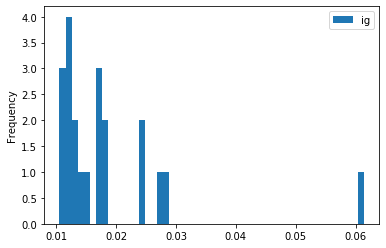

In [53]:
%matplotlib inline
ig.plot.hist(bins=50)

In [54]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [55]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_TF)
X.shape

(1783, 21)

In [56]:
print(X.toarray()[0:1])

[[0.19880219 0.         0.         0.         0.         0.
  0.56695143 0.         0.48070841 0.         0.46425513 0.
  0.32965742 0.         0.         0.         0.         0.28940688
  0.         0.         0.        ]]


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, full_data['target'], test_size=0.30, random_state=42)

In [58]:
X_train.shape

(1248, 21)

In [59]:
X_test.shape

(535, 21)

In [72]:
nb = MultinomialNB().fit(X_train, y_train)
svm = svm.SVC().fit(X_train,y_train)
tree = tree.DecisionTreeClassifier().fit(X_train,y_train)
logr = LogisticRegression().fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [75]:
nbc = MultinomialNB()
svmc = svm.SVC()
treec = tree.DecisionTreeClassifier()
logr = LogisticRegression()

<h1> Realiza o cross validation </h1>

In [76]:
nb_scores = cross_val_score(nbc, X, full_data['target'], cv=5)
svm_scores = cross_val_score(svmc, X, full_data['target'], cv=5)
tree_scores = cross_val_score(treec, X, full_data['target'], cv=5)
logr_scores = cross_val_score(logr, X, full_data['target'], cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

In [78]:
print(treec)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [77]:
print(nb_scores)
print(svm_scores)
print(tree_scores)
print(logr_scores)

[0.90782123 0.89355742 0.88202247 0.88202247 0.89606742]
[0.84636872 0.8487395  0.86235955 0.87359551 0.85955056]
[0.94413408 0.91316527 0.88202247 0.88764045 0.91011236]
[0.91340782 0.87114846 0.86797753 0.87640449 0.8988764 ]


In [68]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def print_metrics(y_true,y_predicted):
    acc = accuracy_score(y_test.values,y_predicted)
    print('Acurácia: ' + str(acc))
    #accuracy_score(y_true, y_predicted)
    print('Matriz de Confusão:' )
    print(confusion_matrix(y_true, y_predicted, labels=[0, 1]))
    print('Recall')
    print(recall_score(y_true, y_predicted, average='macro')  )
    print('Precision')
    print(precision_score(y_true, y_predicted, average='macro')  )
    print('F1-Score')
    print(f1_score(y_true, y_predicted, average='macro')  )

In [69]:
print('Naive Bayes')
print_metrics(y_test,nb.predict(X_test))
print('\n')
print('Decision Tree')
print_metrics(y_test,tree.predict(X_test))
print('\n')
print('Suport Vector Machines')
print_metrics(y_test,svm.predict(X_test))
print('\n')
print('Logistic Regressor')
print_metrics(y_test,logr.predict(X_test))

Naive Bayes
Acurácia: 0.9102803738317757
Matriz de Confusão:
[[450  10]
 [ 38  37]]
Recall
0.7357971014492753
Precision
0.8546825950470875
F1-Score
0.7779622328283876


Decision Tree
Acurácia: 0.8990654205607477
Matriz de Confusão:
[[437  23]
 [ 31  44]]
Recall
0.7683333333333333
Precision
0.7952385508355657
F1-Score
0.7807643273433706


Suport Vector Machines
Acurácia: 0.8728971962616823
Matriz de Confusão:
[[459   1]
 [ 67   8]]
Recall
0.5522463768115942
Precision
0.8807562315166877
F1-Score
0.5607553366174056


Logistic Regressor
Acurácia: 0.9121495327102803
Matriz de Confusão:
[[450  10]
 [ 37  38]]
Recall
0.7424637681159421
Precision
0.8578456536618755
F1-Score
0.7841278835174835


In [79]:
print('Naive Bayes')
print_metrics(y_test,nbc.predict(X_test))
print('\n')
print('Decision Tree')
print_metrics(y_test,treec.predict(X_test))
print('\n')
print('Suport Vector Machines')
print_metrics(y_test,svmc.predict(X_test))
print('\n')
print('Logistic Regressor')
print_metrics(y_test,logr.predict(X_test))

Naive Bayes


NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.